In [1]:
import os, re, pickle
from pprint import pprint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
import pyLDAvis.gensim
import pyLDAvis

from wordcloud import WordCloud

C:\Users\prann\anaconda3\envs\analytics\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
quotes = pd.read_excel("data.xlsx")
quotes

,Quote,Person,Date
0,What the crap is an ITE?,Vikram,2021-02-26 00:00:00
1,Siri go die in a hole,Vikram,NaN
2,I have never had the life destroying addiction...,Vikram,2021-03-03 00:00:00
3,Teachers have to be well read,Mr Wong,2021-03-03 00:00:00
4,Justin: I have nail polish on right now. Ms Yu...,"Justin, Ms Yuen",2021-03-03 00:00:00
...,...,...,...
633,"Edden: ""Oh shit I am going to get diabetes"" Ri...","Edden, Riane",2023-08-04 00:00:00
634,ah yes I'm a year older so time to learn smth ...,Prannaya,2023-08-04 00:00:00
635,"I don't have to win, I just need to make [Ms Y...",Zhi Yuan,2023-08-07 00:00:00
636,I got many years to go… I’m stuck here,Mr Lim Teck Choow,2023-08-07 00:00:00


In [3]:
indiv = quotes[~quotes.Person.str.contains(",") & (~quotes.Date.isna()) & (quotes.Date != "Multiple Dates") & ~(quotes.Person.isin([
    "Multiple People", "Hivemind", "Dr Bi", "Mr Shao-Horng"
]))]
indiv

C:\Users\prann\anaconda3\envs\analytics\lib\site-packages\pandas\core\algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


,Quote,Person,Date
0,What the crap is an ITE?,Vikram,2021-02-26 00:00:00
2,I have never had the life destroying addiction...,Vikram,2021-03-03 00:00:00
3,Teachers have to be well read,Mr Wong,2021-03-03 00:00:00
6,Powerpoint sucks,Mr Yuen,2021-03-04 00:00:00
7,I approach the stool of overly aggressive meta...,Vikram,2021-03-05 00:00:00
...,...,...,...
632,Men always respect lady because of romantic or...,Mr Lim Teck Choow,2023-08-04 00:00:00
634,ah yes I'm a year older so time to learn smth ...,Prannaya,2023-08-04 00:00:00
635,"I don't have to win, I just need to make [Ms Y...",Zhi Yuan,2023-08-07 00:00:00
636,I got many years to go… I’m stuck here,Mr Lim Teck Choow,2023-08-07 00:00:00


Text(0.5, 1.0, 'Number of Quotes per Person')

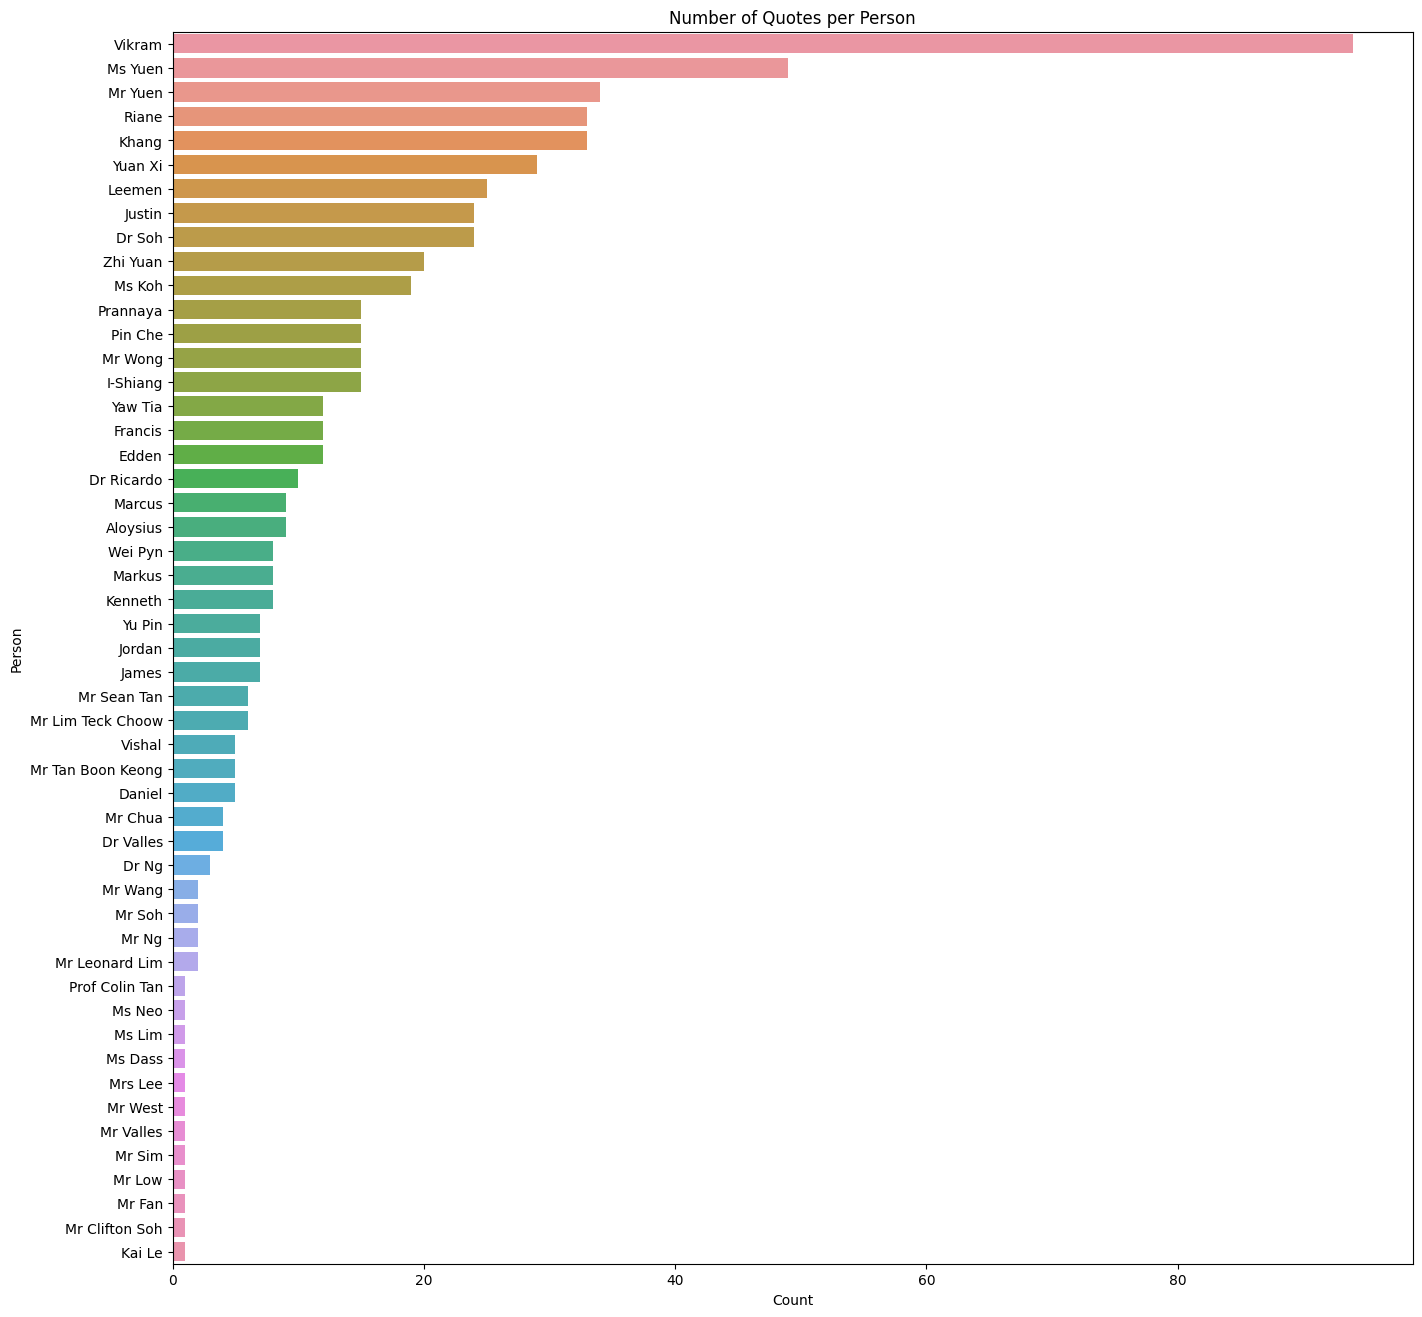

In [4]:
plt.figure(figsize=(16, 16))
sns.barplot(indiv.groupby("Person").Date.count().reset_index().sort_values(["Date", "Person"], ascending=False), y="Person", x="Date")
plt.xlabel("Count")
plt.title("Number of Quotes per Person")

Text(0.5, 1.0, 'Number of Quotes per Month')

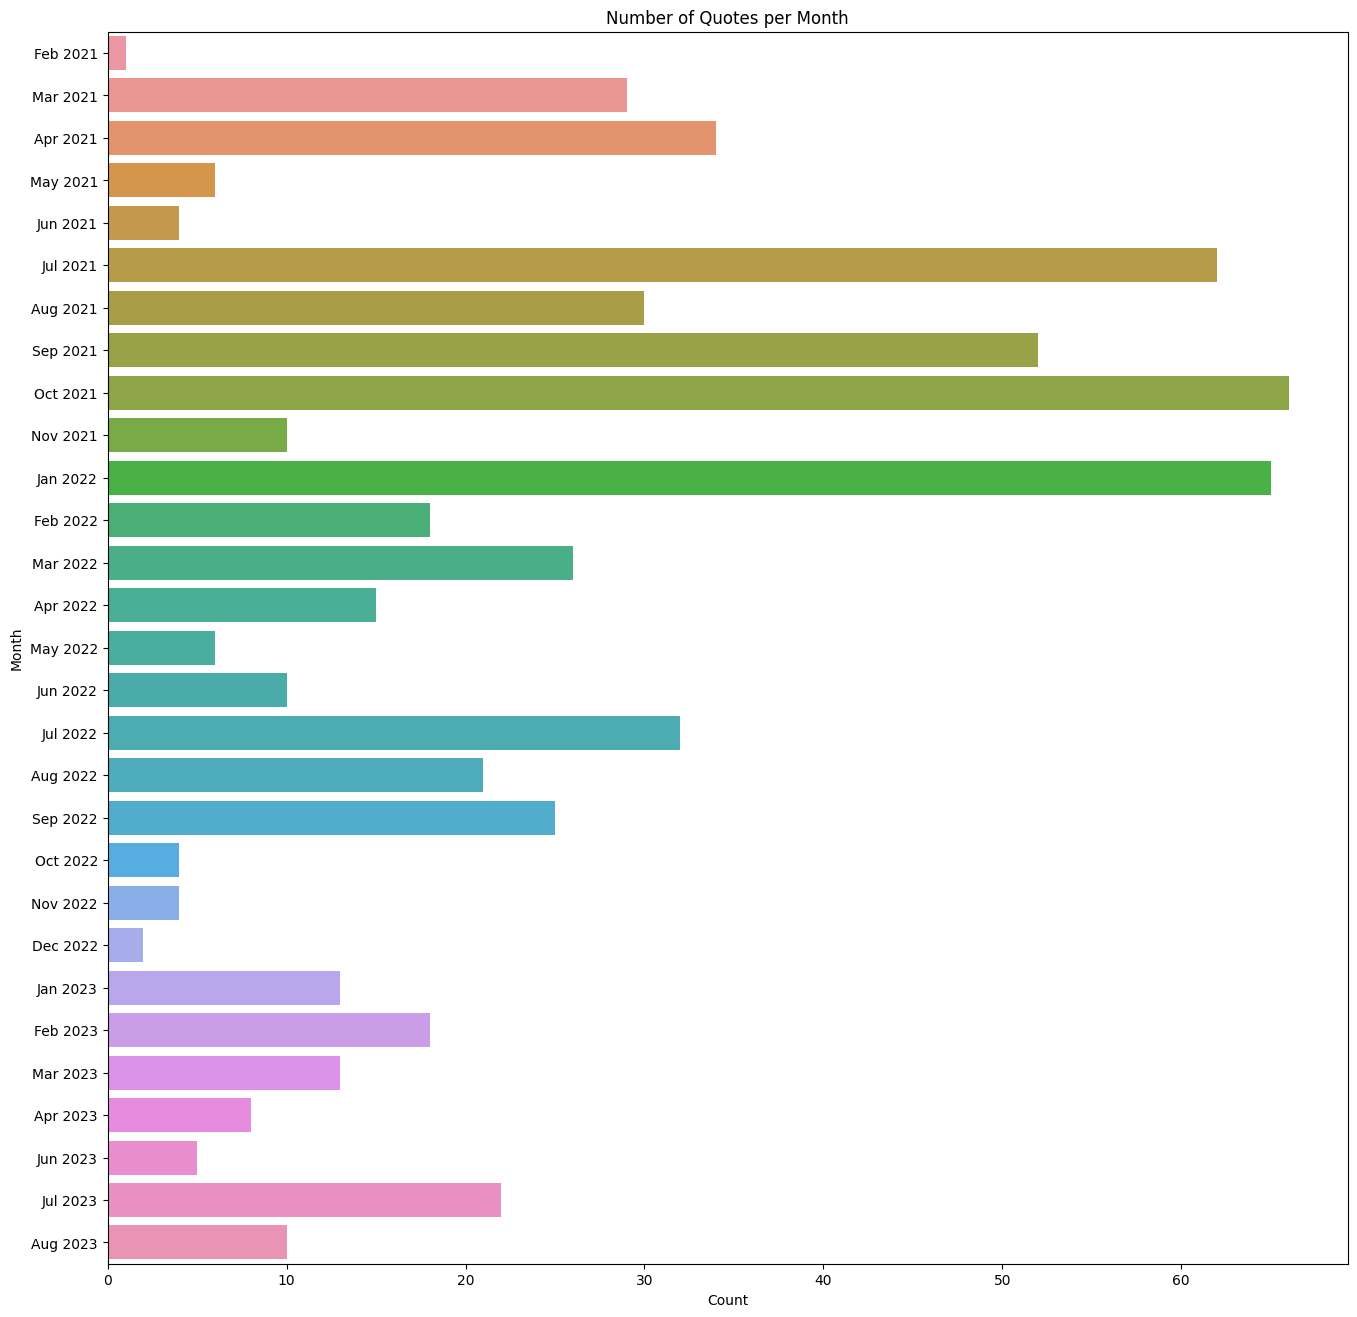

In [5]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.figure(figsize=(16, 16))
sns.barplot(indiv.Date.astype("datetime64").apply(lambda d: (d.year, d.month)).value_counts().sort_index().rename(index=lambda d:f"{months[d[1]-1]} {d[0]}").reset_index().rename(columns={"index": "Month", "Date": "Count"}), y="Month", x="Count")
plt.title("Number of Quotes per Month")

In [6]:
texts = indiv.Quote.str.replace(r'[,\.!?:-]', "", regex=True).str.lower().tolist()

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True) # deacc=True removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data_words = list(sent_to_words(texts))
data_words = remove_stopwords(data_words)

### Prepare a WordCloud

C:\Users\prann\anaconda3\envs\analytics\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


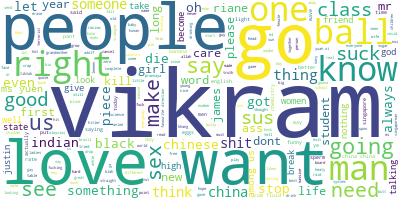

In [7]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

final_text = ""
for words in data_words: final_text += " ".join(words)+" "

wordcloud.generate(final_text)

wordcloud.to_image()

### Performing Latent Dirichlet Allocation (LDA)

In [8]:
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]

num_topics = 6
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"like" + 0.009*"people" + 0.008*"yes" + 0.007*"man" + 0.006*"break" + '
  '0.006*"grandmother" + 0.006*"go" + 0.005*"get" + 0.005*"first" + '
  '0.005*"one"'),
 (1,
  '0.014*"like" + 0.009*"nice" + 0.008*"got" + 0.007*"sex" + 0.007*"need" + '
  '0.006*"man" + 0.006*"heaty" + 0.005*"us" + 0.005*"cum" + 0.004*"one"'),
 (2,
  '0.012*"get" + 0.009*"vikram" + 0.007*"sus" + 0.006*"say" + 0.005*"right" + '
  '0.005*"like" + 0.004*"erase" + 0.004*"riane" + 0.004*"may" + '
  '0.004*"students"'),
 (3,
  '0.017*"vikram" + 0.016*"like" + 0.010*"balls" + 0.010*"want" + 0.007*"wave" '
  '+ 0.005*"sex" + 0.005*"prannaya" + 0.005*"bitter" + 0.005*"make" + '
  '0.005*"girl"'),
 (4,
  '0.018*"china" + 0.011*"going" + 0.009*"good" + 0.007*"vikram" + '
  '0.007*"would" + 0.007*"class" + 0.007*"james" + 0.006*"word" + 0.004*"like" '
  '+ 0.004*"get"'),
 (5,
  '0.009*"get" + 0.008*"us" + 0.008*"vikram" + 0.008*"shit" + 0.008*"oh" + '
  '0.008*"mr" + 0.007*"people" + 0.006*"bully" + 0.006*"love

In [9]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(LDAvis_prepared, 'results/ldavis_prepared_'+ str(num_topics) +'.html')

C:\Users\prann\anaconda3\envs\analytics\lib\site-packages\scipy\sparse\_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
C:\Users\prann\anaconda3\envs\analytics\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
